In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
sns.set(style='white', context='notebook', palette='deep')

# Loading the data

In [4]:
train = pd.read_csv(r"C:\Users\gasse\OneDrive\Desktop\10 OCR\OCR\data\mnist\train.csv")
test = pd.read_csv(r"C:\Users\gasse\OneDrive\Desktop\10 OCR\OCR\data\mnist\test.csv")

In [6]:
train.shape

(42000, 785)

# Label Column is Output

In [7]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)

# free some space
# del train

Y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

# Checking Nulls

In [8]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

# Normalizing The Data

In [10]:
X_train = X_train / 255.0
test = test / 255.0

# Reshaping Image In 3 Dimensions 

In [11]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# Encoding Labels To One Hot Vectors

In [12]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [14]:
# Set the random seed
random_seed = 2

# Spliting The Train And The Validation

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

# Showing Some Samples

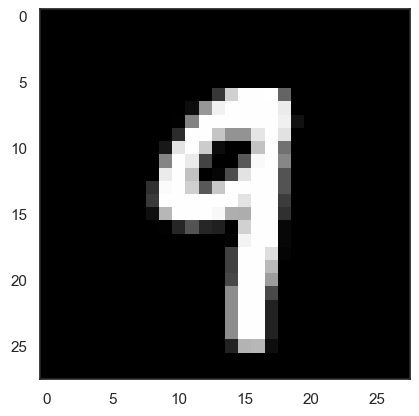

In [17]:
plt.imshow(X_train[2][:,:,0],cmap = 'gray')

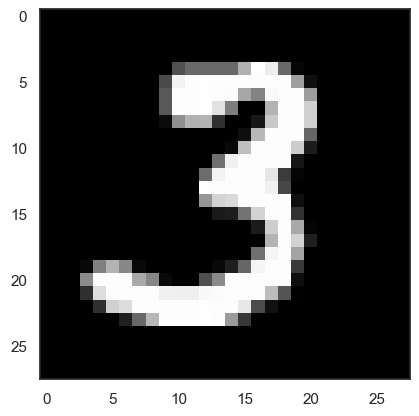

In [19]:
g = plt.imshow(X_train[6][:,:,0],cmap = 'gray')

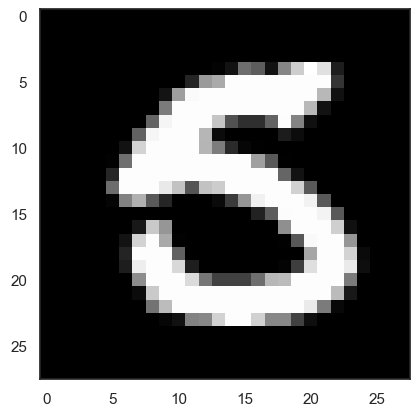

In [20]:
g = plt.imshow(X_train[4][:,:,0],cmap = 'gray')

# Building The CNN Model

In [21]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

C:\Users\gasse\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# Define the optimizer (correct Keras 3 syntax)
optimizer = RMSprop(
    learning_rate=0.001,
    rho=0.9,
    epsilon=1e-07
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',   # Keras 3 renamed val_acc → val_accuracy
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=1e-5
)

epochs = 30
batch_size = 85

# Data Augmentation

In [32]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# Fitting The Model

In [33]:
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=2,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

Epoch 1/30
444/444 - 37s - 82ms/step - accuracy: 0.9606 - loss: 0.1327 - val_accuracy: 0.9879 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 2/30


C:\Users\gasse\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


444/444 - 1s - 3ms/step - accuracy: 0.9529 - loss: 0.1822 - val_accuracy: 0.9869 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 3/30
444/444 - 35s - 79ms/step - accuracy: 0.9715 - loss: 0.0949 - val_accuracy: 0.9879 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 4/30
444/444 - 1s - 3ms/step - accuracy: 0.9765 - loss: 0.0587 - val_accuracy: 0.9907 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 5/30
444/444 - 35s - 78ms/step - accuracy: 0.9762 - loss: 0.0804 - val_accuracy: 0.9874 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 6/30
444/444 - 1s - 3ms/step - accuracy: 0.9647 - loss: 0.1072 - val_accuracy: 0.9919 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 7/30
444/444 - 34s - 78ms/step - accuracy: 0.9799 - loss: 0.0683 - val_accuracy: 0.9936 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 8/30
444/444 - 1s - 3ms/step - accuracy: 0.9529 - loss: 0.1306 - val_accuracy: 0.9907 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 9/30
444/444 - 34s - 78ms/step - accuracy: 0.9813 - lo

# Confusion Matrix

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


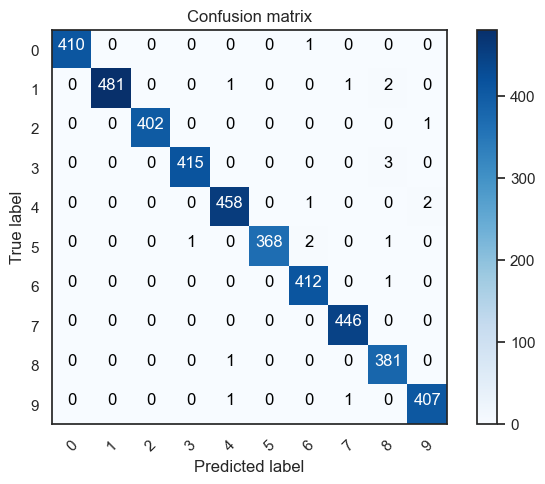

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

# Displaying Some Error Results

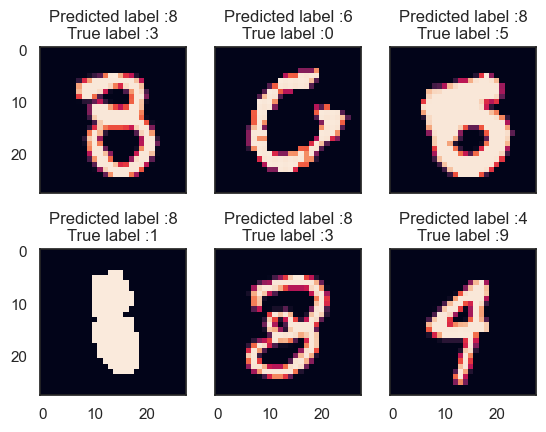

In [35]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Predicting Images Based On Our Model

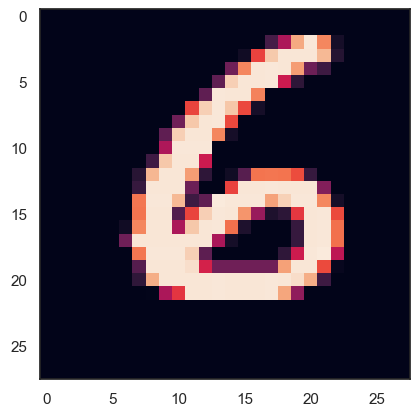

In [36]:
plt.imshow(X_val[0])

In [37]:
model.predict(np.reshape(X_val[0],[1,28,28,1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


array([[1.0387781e-09, 1.4772335e-15, 1.0272036e-15, 8.3792845e-16,
        3.6862980e-15, 2.2716193e-09, 1.0000000e+00, 4.9516715e-20,
        3.0460354e-10, 5.0821716e-14]], dtype=float32)

In [48]:
print ("The prediction is " , "(" , np.argmax(model.predict(np.reshape(X_val[0],[1,28,28,1]))) , ")")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The prediction is  ( 6 )


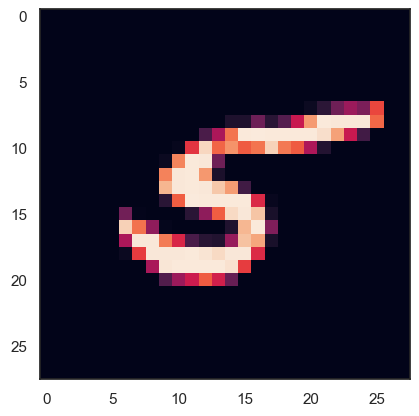

In [39]:
plt.imshow(X_val[2])

In [40]:
model.predict(np.reshape(X_val[2],[1,28,28,1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


array([[1.27651965e-14, 1.00915600e-13, 1.27346957e-15, 1.15932719e-09,
        3.48122518e-13, 1.00000000e+00, 9.36790576e-11, 1.02946320e-15,
        5.65823811e-11, 1.17586241e-09]], dtype=float32)

In [47]:
print ("The prediction is " , "(" , np.argmax(model.predict(np.reshape(X_val[2],[1,28,28,1]))) , ")")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
The prediction is  ( 5 )


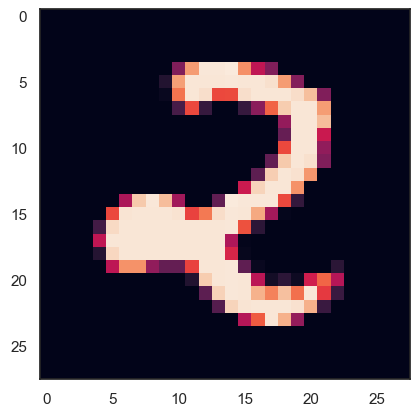

In [49]:
plt.imshow(X_val[5])

In [50]:
model.predict(np.reshape(X_val[5],[1,28,28,1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[1.7039621e-09, 5.1288845e-10, 9.9999988e-01, 4.4842615e-08,
        1.5199175e-10, 7.1433766e-13, 9.3693338e-11, 4.5708568e-08,
        1.2563300e-08, 1.7175918e-09]], dtype=float32)

In [51]:
print ("The prediction is " , "(" , np.argmax(model.predict(np.reshape(X_val[5],[1,28,28,1]))) , ")")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The prediction is  ( 2 )


# Prediction Images That Made Manually

In [53]:
def PredictImage(Image) :
  print("The prediction is " , "(" , np.argmax(model.predict(np.reshape(Image,[1,28,28,1]))) , ")")
  plt.imshow(Image)

In [55]:
import cv2

p = cv2.imread(r"C:\Users\gasse\OneDrive\Desktop\10 OCR\OCR\05.png", cv2.IMREAD_GRAYSCALE)
p.shape

(106, 110)

# Resizing image

In [56]:
p = cv2.resize(p,(28,28))
p.shape

(28, 28)

(28, 28, 1)

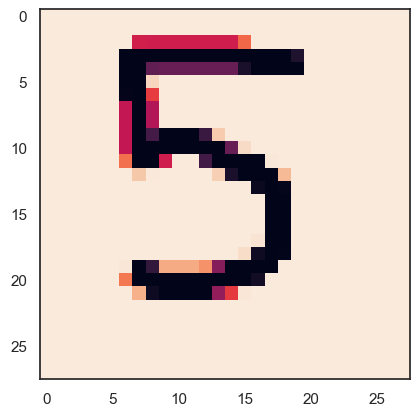

In [57]:
plt.imshow(p)

# converts a flat array into a 28×28 grayscale image
p = np.reshape(p,[28,28,1])
p.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
The prediction is  ( 5 )


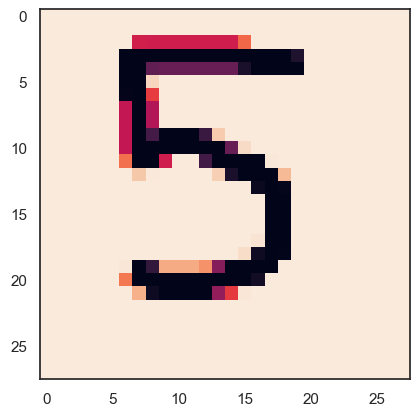

In [58]:
PredictImage(p )

In [64]:
import cv2

p = cv2.imread(r"C:\Users\gasse\OneDrive\Desktop\10 OCR\OCR\03.png", cv2.IMREAD_GRAYSCALE)
p.shape

(106, 110)

# Resizing Image

In [65]:
p = cv2.resize(p,(28,28))
p.shape

(28, 28)

(28, 28, 1)

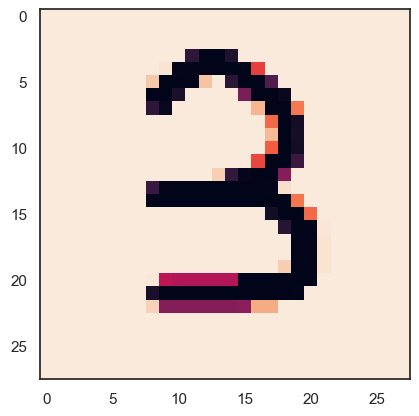

In [66]:
plt.imshow(p)

# converts a flat array into a 28×28 grayscale image
p = np.reshape(p,[28,28,1])
p.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
The prediction is  ( 3 )


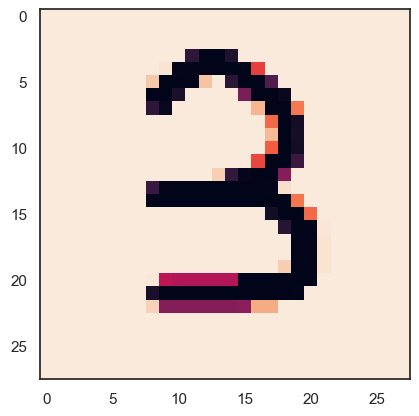

In [67]:
PredictImage(p )